# An√°lisis Exploratorio de las Etiquetas

### Importar librer√≠as



In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib

In [96]:
plt.style.use("seaborn-v0_8-darkgrid")

### Limpiar el data set
(Eliminar registros que no son del pecho)

In [97]:
df1 = pd.read_csv("../datos/labels/train_predicted_labels.csv")   

with open("../datos/labels/no_chest_train.txt", "r") as f:
    rutas_largas = f.read().splitlines()
nombres_largos = [ruta.split("/")[-1] for ruta in rutas_largas]
df = df1[~df1.iloc[:,0].isin(nombres_largos)].copy()

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46397 entries, 0 to 47148
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   VolumeName                          46397 non-null  object
 1   Medical material                    46397 non-null  int64 
 2   Arterial wall calcification         46397 non-null  int64 
 3   Cardiomegaly                        46397 non-null  int64 
 4   Pericardial effusion                46397 non-null  int64 
 5   Coronary artery wall calcification  46397 non-null  int64 
 6   Hiatal hernia                       46397 non-null  int64 
 7   Lymphadenopathy                     46397 non-null  int64 
 8   Emphysema                           46397 non-null  int64 
 9   Atelectasis                         46397 non-null  int64 
 10  Lung nodule                         46397 non-null  int64 
 11  Lung opacity                        46397 non-null  int64 


In [99]:
df.head()

VolumeName  Medical material  Arterial wall calcification  \
0  train_1_a_1.nii.gz                 0                            1   
1  train_1_a_2.nii.gz                 0                            1   
2  train_2_a_1.nii.gz                 0                            1   
3  train_2_a_2.nii.gz                 0                            1   
4  train_3_a_1.nii.gz                 0                            1   

   Cardiomegaly  Pericardial effusion  Coronary artery wall calcification  \
0             0                     0                                   0   
1             0                     0                                   0   
2             0                     0                                   0   
3             0                     0                                   0   
4             1                     0                                   1   

   Hiatal hernia  Lymphadenopathy  Emphysema  Atelectasis  Lung nodule  \
0              0                0          0            1            0   
1              0                0          0            1            0   
2              0                0          1            1            1   
3              0                0          1            1            1   
4              0                1          0            0            1   

   Lung opacity  Pulmonary fibrotic sequela  Pleural effusion  \
0             1                           0                 0   
1             1                           0                 0   
2             0                           0                 0   
3             0                           0                 0   
4             1                           1                 0   

   Mosaic attenuation pattern  Peribronchial thickening  Consolidation  \
0                           0                         1              1   
1                           0                         1              1   
2                           0                         1              0   
3                           0                         1              0   
4                           0                         1              0   

   Bronchiectasis  Interlobular septal thickening  
0               0                               0  
1               0                               0  
2               0                               0  
3               0                               0  
4               1                               0

In [100]:
disease_cols = df.columns[2:] #1 si medical material es enfermedad y 2 si no
disease_counts = df[disease_cols].sum().sort_values(ascending=False)
disease_counts


Lung nodule                           21096
Lung opacity                          17147
Arterial wall calcification           13016
Pulmonary fibrotic sequela            12411
Atelectasis                           11968
Lymphadenopathy                       11939
Coronary artery wall calcification    11663
Emphysema                              8996
Consolidation                          8223
Hiatal hernia                          6618
Pleural effusion                       5593
Cardiomegaly                           5025
Peribronchial thickening               4911
Bronchiectasis                         4691
Interlobular septal thickening         3688
Mosaic attenuation pattern             3487
Pericardial effusion                   3332
dtype: int64

In [101]:
total_registros = disease_counts.sum()
print(f"Total de registros: {total_registros:,}")


Total de registros: 153,804


# Gr√°ficas

### Barras

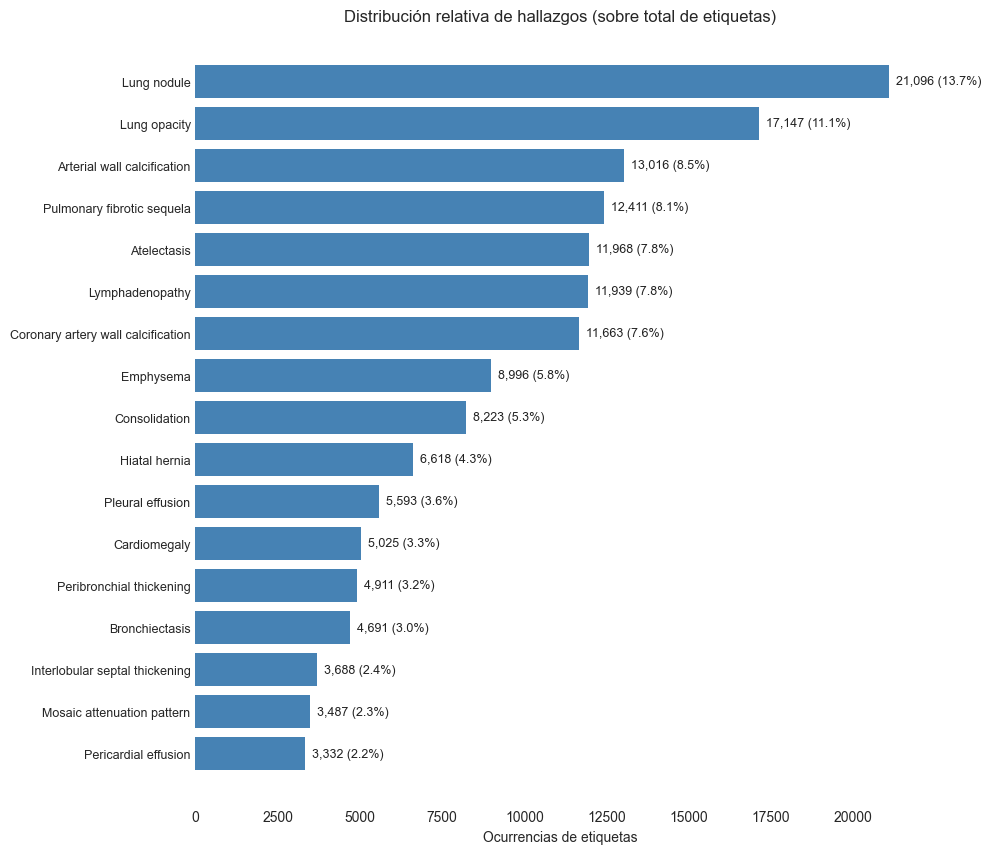

In [102]:
counts = disease_counts.sort_values(ascending=True)
total_hallazgos = counts.sum()
disease_percentages = counts / total_hallazgos * 100

plt.figure(figsize=(10, 0.45*len(counts)+1), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

ax.barh(range(len(counts)), counts.values, color="steelblue")

m = counts.max()
for i, (c, p) in enumerate(zip(counts.values, disease_percentages.values)):
    ax.text(c + m*0.01, i, f"{c:,} ({p:.1f}%)", va='center', fontsize=9, color="#222")

ax.set_yticks(range(len(counts)))
ax.set_yticklabels(counts.index, fontsize=9)
ax.set_xlabel("Ocurrencias de etiquetas")
ax.set_title("Distribuci√≥n relativa de hallazgos (sobre total de etiquetas)")

for spine in ("top","right"):
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

### Nota
La gr√°fica muestra la composici√≥n relativa de todas las etiquetas positivas del conjunto: cada barra indica cu√°ntas veces se registr√≥ un hallazgo y el porcentaje entre par√©ntesis corresponde a su proporci√≥n sobre el total de etiquetas (no es la prevalencia de pacientes, sino la fracci√≥n de todas las anotaciones positivas).

### Heat map

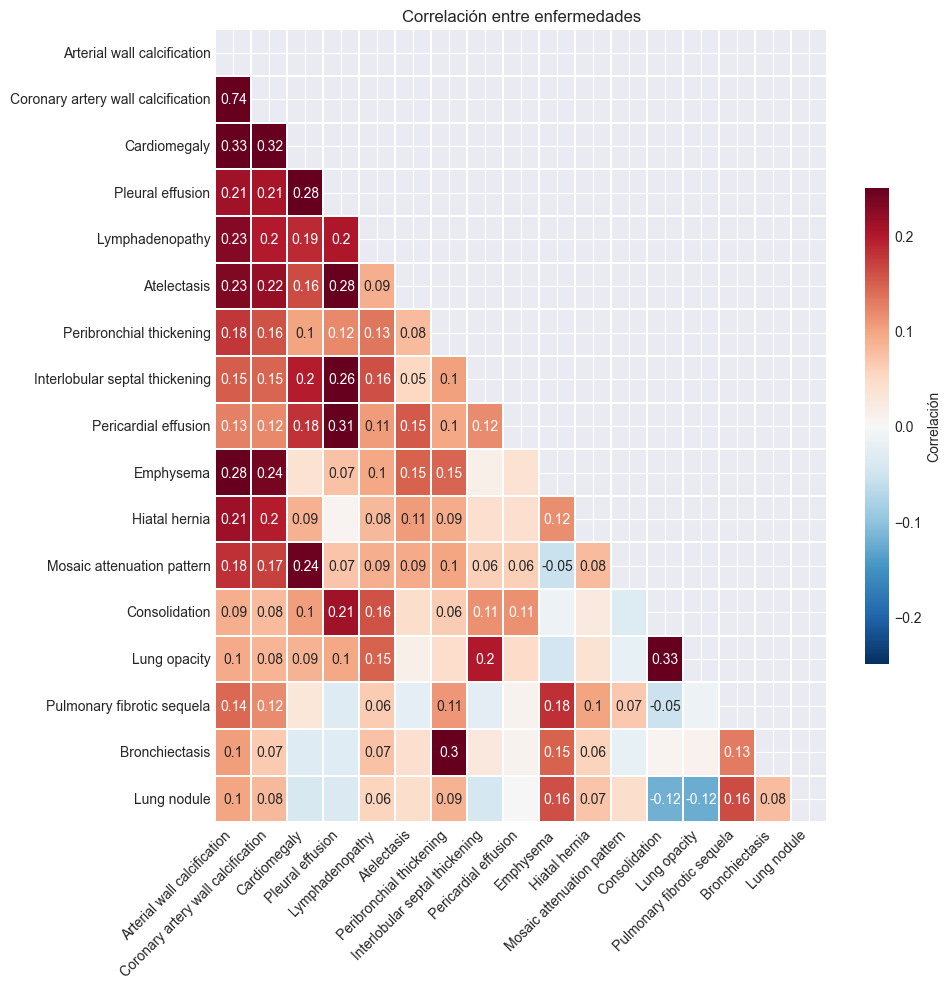

In [103]:
corr = df[disease_cols].corr()
vals, vecs = np.linalg.eigh(corr)
pc1 = vecs[:, vals.argmax()]
order = np.argsort(pc1)
corr_o = corr.iloc[order, order]

mask = np.triu(np.ones_like(corr_o, dtype=bool))

ann = corr_o.round(2).astype(str)
ann[np.abs(corr_o.values) < 0.05] = ""

plt.figure(figsize=(10,10))
sns.heatmap(
    corr_o,
    mask=mask,
    cmap="RdBu_r",
    center=0,
    vmin=-0.25, vmax=0.25,
    linewidths=.3,
    annot=ann,
    fmt="",
    cbar_kws={"shrink":0.6, "label":"Correlaci√≥n"}
)
plt.title("Correlaci√≥n entre enfermedades")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Nota

Este mapa muestra qu√© tan seguido aparecen juntas dos condiciones en los mismos estudios. Cada cuadradito compara un par:

Rojo: las dos suelen salir juntas m√°s de lo esperado.
Azul: casi no coinciden (aparecen separadas).
Blanco o muy claro: no hay relaci√≥n clara.
La escala va de -0.25 a +0.25 (valores fuera de ese rango se ‚Äúrecortan‚Äù para que los colores se distingan mejor). No significa porcentaje, solo indica fuerza y direcci√≥n de la relaci√≥n. No implica causa; solo refleja coincidencia en este conjunto de datos

# **Afecciones tor√°cicas:**

## ü´Ä **Cardiovasculares**

### **Arterial wall calcification** (Calcificaci√≥n de la pared arterial)

**¬øQu√© es?** Dep√≥sitos de calcio en la pared arterial (frecuente en aorta, coronarias y arterias perif√©ricas).

**Causas:** Aterosclerosis asociada a envejecimiento y factores de riesgo: diabetes mellitus, enfermedad renal cr√≥nica, hipertensi√≥n, dislipidemia, tabaquismo e inflamaci√≥n cr√≥nica.

**Significado:** Indicador de aterosclerosis, rigidez arterial y degeneraci√≥n vascular cr√≥nica. 

**En CT:** Focos o l√≠neas hiperdensas adheridas a la pared (visibles sin contraste). 

**Relevancia:** Marcador de riesgo cardiovascular y posible dificultad t√©cnica en procedimientos.  

In [104]:
cond = "Arterial wall calcification"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Arterial wall calcification: 13,016 registros (8.46%).


### **Coronary artery wall calcification** (Calcificaci√≥n de la pared arterial coronaria)

**¬øQu√© es?** Dep√≥sitos de calcio en la pared de las arterias coronarias.

**Causas:** Aterosclerosis relacionada con envejecimiento y factores de riesgo cardiovascular: diabetes mellitus, enfermedad renal cr√≥nica (alteraci√≥n calcio-fosfato), hipertensi√≥n, dislipidemia, tabaquismo e inflamaci√≥n cr√≥nica.

**Significado:** Indicador de aterosclerosis coronaria, rigidez arterial y carga ateroscler√≥tica total.

**En CT:** Se visualiza como focos o l√≠neas hiperdensas en la pared coronaria (sin contraste). Se cuantifica con el Agatston score.

**Relevancia:** Marcador de riesgo cardiovascular mayor, predictor de eventos coronarios (infarto de miocardio), y √∫til en estratificaci√≥n de riesgo para prevenci√≥n.

In [105]:
cond = "Coronary artery wall calcification"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Coronary artery wall calcification: 11,663 registros (7.58%).


### **Cardiomegaly** (Cardiomegalia)

**¬øQu√© es?** Aumento del tama√±o global del coraz√≥n o de sus cavidades, visible en estudios de imagen.

**Causas:** Hipertensi√≥n arterial cr√≥nica, cardiopat√≠a isqu√©mica, miocardiopat√≠as (dilatada, hipertr√≥fica, restrictiva), valvulopat√≠as (estenosis o insuficiencia a√≥rtica/mitral), enfermedad peric√°rdica (derrame), anemia cr√≥nica, alteraciones tiroideas, alcoholismo.

**Significado:** Indica sobrecarga de presi√≥n o volumen, remodelado card√≠aco y riesgo de insuficiencia card√≠aca.

**En CT:** Coraz√≥n de tama√±o aumentado, con di√°metros de cavidades dilatados o masa mioc√°rdica incrementada. En Rx de t√≥rax: √≠ndice cardiotor√°cico > 0.5.

**Relevancia:** Marcador de insuficiencia card√≠aca, riesgo de arritmias y predictor de mal pron√≥stico cardiovascular.

In [106]:
cond = "Cardiomegaly"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Cardiomegaly: 5,025 registros (3.27%).


### **Pericardial effusion** (Derrame peric√°rdico)

**¬øQu√© es?** Acumulaci√≥n anormal de l√≠quido en el espacio peric√°rdico.

**Causas:** Infecciones (virus, bacterias, tuberculosis), neoplasias, insuficiencia card√≠aca, insuficiencia renal (uremia), enfermedades autoinmunes (lupus, artritis reumatoide), traumatismos, postquir√∫rgico, hipotiroidismo, idiop√°tico.

**Significado:** Indica inflamaci√≥n, lesi√≥n o compromiso sist√©mico; puede evolucionar a taponamiento card√≠aco si el volumen es significativo o de r√°pida acumulaci√≥n.

**En CT:** Engrosamiento aparente del espacio peric√°rdico con l√≠quido hipodenso que rodea al coraz√≥n; en ecocardiograf√≠a se confirma y cuantifica.

**Relevancia:** Puede comprometer el llenado card√≠aco (taponamiento), generar inestabilidad hemodin√°mica y requerir drenaje (pericardiocentesis).

In [107]:
cond = "Pericardial effusion"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Pericardial effusion: 3,332 registros (2.17%).


## ü´Å **Pulmonares**


### **Emphysema** (Efisema pulmonar)

**¬øQu√© es?** Enfermedad pulmonar caracterizada por la destrucci√≥n irreversible de las paredes alveolares y dilataci√≥n anormal de los espacios a√©reos distales.

**Causas:** Principalmente tabaquismo; tambi√©n d√©ficit de alfa-1 antitripsina, exposici√≥n a biomasa, contaminaci√≥n ambiental y envejecimiento pulmonar acelerado.

**Significado:** Indica da√±o cr√≥nico de la arquitectura pulmonar con p√©rdida de la elasticidad, atrapamiento a√©reo y alteraci√≥n del intercambio gaseoso.

**En CT:** √Åreas de baja atenuaci√≥n sin paredes visibles (‚Äúblack holes‚Äù), hiperinflaci√≥n, disminuci√≥n del calibre vascular y bullas enfisematosas.

**Relevancia:** Componente central de la EPOC, causa disnea progresiva, deterioro funcional y aumento de la morbimortalidad respiratoria y cardiovascular.

In [108]:
cond = "Emphysema"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Emphysema: 8,996 registros (5.85%).



### **Atelectasis** (Atelectasia)

**¬øQu√© es?** Colapso parcial o completo del par√©nquima pulmonar por p√©rdida de aire en los alv√©olos.

**Causas:** Obstrucci√≥n bronquial (tapones de moco, cuerpos extra√±os, tumores), compresi√≥n extr√≠nseca (derrame pleural, neumot√≥rax, masas), hipoventilaci√≥n postoperatoria, fibrosis pulmonar.

**Significado:** Indica p√©rdida de volumen pulmonar y compromiso en la ventilaci√≥n, puede ser reversible si se trata la causa.

**En CT:** √Åreas de aumento de densidad con retracci√≥n de estructuras adyacentes (desplazamiento de cisuras, bronquios, vasos), reducci√≥n del volumen pulmonar afectado; en Rx se ve opacidad con signos de p√©rdida de volumen.

**Relevancia:** Puede causar hipoxemia, predisponer a infecciones y complicar procedimientos; hallazgo com√∫n en pacientes hospitalizados y postquir√∫rgicos.

In [109]:
cond = "Atelectasis"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Atelectasis: 11,968 registros (7.78%).


### **Lung nodule** (N√≥dulo pulmonar)

**¬øQu√© es?** Lesi√≥n redondeada u ovalada en el par√©nquima pulmonar, de ‚â§3 cm de di√°metro, rodeada por pulm√≥n normal.

**Causas:** Infecciones (tuberculosis, histoplasmosis, otras micosis), lesiones benignas (hamartomas, malformaciones vasculares), procesos inflamatorios (sarcoidosis, neumon√≠a organizada) y neoplasias (carcinoma broncog√©nico, met√°stasis, linfoma).

**Significado:** Puede ser hallazgo incidental o manifestaci√≥n de enfermedad infecciosa, inflamatoria o neopl√°sica; requiere valoraci√≥n de riesgo.

**En CT:** N√≥dulo s√≥lido, sub-s√≥lido o en vidrio esmerilado; se eval√∫an bordes, densidad, calcificaci√≥n, tama√±o y crecimiento en controles seriados.

**Relevancia:** La principal preocupaci√≥n es descartar malignidad; su detecci√≥n y seguimiento son clave en la prevenci√≥n y diagn√≥stico temprano de c√°ncer de pulm√≥n.



In [110]:
cond = "Lung nodule"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Lung nodule: 21,096 registros (13.72%).


### **Lung opacity** (Opacidad pulmonar)

**¬øQu√© es?** √Årea de aumento en la atenuaci√≥n del par√©nquima pulmonar que reduce la visualizaci√≥n de los vasos y estructuras adyacentes.

**Causas:** Procesos infecciosos (neumon√≠a bacteriana, viral, mic√≥tica, tuberculosis), inflamatorios (neumonitis, sarcoidosis), hemorr√°gicos (hemorragia alveolar), neopl√°sicos (adenocarcinoma, linfoma, met√°stasis) y ocupaci√≥n alveolar por l√≠quido (edema pulmonar, aspiraci√≥n).

**Significado:** Refleja p√©rdida de la aireaci√≥n pulmonar y puede ser transitoria o persistente seg√∫n la etiolog√≠a.

**En CT:** Se observa como consolidaci√≥n, vidrio esmerilado o patr√≥n mixto; se eval√∫a extensi√≥n, distribuci√≥n y asociaci√≥n con otras lesiones.

**Relevancia:** Requiere correlaci√≥n cl√≠nica y seguimiento, ya que abarca desde infecciones benignas hasta neoplasias malignas.

In [111]:
cond = "Lung opacity"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Lung opacity: 17,147 registros (11.15%).


### **Pulmonary fibrotic sequela** (Secuela fibr√≥tica pulmonar)

**¬øQu√© es?** Cambios fibr√≥ticos residuales en el par√©nquima pulmonar tras procesos inflamatorios, infecciosos o lesivos previos, caracterizados por cicatrizaci√≥n y distorsi√≥n de la arquitectura pulmonar.

**Causas:** Secuelas de neumon√≠as graves (incluyendo tuberculosis), infecciones mic√≥ticas, exposici√≥n a polvos inorg√°nicos (neumoconiosis), da√±o pulmonar por radiaci√≥n, enfermedades autoinmunes (artritis reumatoide, esclerosis sist√©mica) y como resultado de s√≠ndrome de distr√©s respiratorio agudo o COVID-19.

**Significado:** Indican da√±o pulmonar cr√≥nico e irreversible con p√©rdida de la elasticidad y disminuci√≥n de la capacidad respiratoria.

**En CT:** Se observan reticulaci√≥n, bronquiectasias por tracci√≥n, engrosamiento septal y patr√≥n en panal de abeja en √°reas avanzadas.

**Relevancia:** Requieren diferenciaci√≥n de fibrosis activa vs. secuela estable; tienen implicaci√≥n pron√≥stica y funcional en la enfermedad pulmonar.

In [112]:
cond = "Pulmonary fibrotic sequela"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Pulmonary fibrotic sequela: 12,411 registros (8.07%).


### **Mosaic attenuation pattern** (Patr√≥n de atenuacion en mosaico)

**¬øQu√© es?** Alteraci√≥n heterog√©nea de la atenuaci√≥n pulmonar en la tomograf√≠a, que se manifiesta como regiones adyacentes de par√©nquima con diferente densidad.

**Causas:** Puede deberse a tres grandes mecanismos: enfermedades de la v√≠a a√©rea (bronquiolitis, asma, bronquiolitis obliterante), alteraciones vasculares (hipertensi√≥n pulmonar cr√≥nica, tromboembolismo pulmonar cr√≥nico) o enfermedades parenquimatosas (neumon√≠as intersticiales, neumon√≠a en organizaci√≥n).

**Significado:** Refleja un proceso subyacente que produce distribuci√≥n desigual del flujo de aire o sangre, o infiltraci√≥n del par√©nquima.

**En CT:** Se observan √°reas hipodensas (hipoatenuadas, atrapamiento a√©reo) junto a zonas hiperdensas (hiperatenuadas, perfusi√≥n aumentada o infiltraci√≥n). El uso de expiraci√≥n en la TC ayuda a identificar atrapamiento a√©reo.

**Relevancia:** Es un hallazgo inespec√≠fico que requiere correlaci√≥n cl√≠nica y funcional para distinguir entre causas de origen vascular, bronquiolar o parenquimatoso.

In [113]:
cond = "Mosaic attenuation pattern"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Mosaic attenuation pattern: 3,487 registros (2.27%).


### **Peribronchial thickening** (Engrosamiento peribronquial)

**¬øQu√© es?** Engrosamiento de las paredes bronquiales y del tejido que rodea a los bronquios, visible en estudios de imagen.

**Causas:** Asociado principalmente a inflamaci√≥n e infecci√≥n (bronquitis aguda, bronquitis cr√≥nica, bronquiolitis), asma, fibrosis qu√≠stica, insuficiencia card√≠aca congestiva y enfermedades intersticiales.

**Significado:** Indica afectaci√≥n inflamatoria, infecciosa o congestiva de la v√≠a a√©rea, y puede ser signo de enfermedad pulmonar obstructiva cr√≥nica (EPOC) o sobrecarga h√≠drica.

**En CT:** Se observa como un engrosamiento de las paredes bronquiales, con apariencia de ‚Äúsigno del anillo‚Äù (bronquio engrosado en corte transversal) o ‚Äúsigno de las v√≠as a√©reas paralelas‚Äù en cortes longitudinales.

**Relevancia:** Es un hallazgo inespec√≠fico pero √∫til para sugerir procesos inflamatorios, infecciosos o congestivos, ayudando en la diferenciaci√≥n entre causas pulmonares y card√≠acas.

In [114]:
cond = "Peribronchial thickening"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Peribronchial thickening: 4,911 registros (3.19%).


### **Consolidation** (Cosolidaci√≥n pulmobar)

**¬øQu√© es?** Sustituci√≥n del aire alveolar por l√≠quido, c√©lulas inflamatorias, sangre, prote√≠nas o tejido, lo que provoca aumento de la densidad pulmonar.

**Causas:** La m√°s com√∫n es la neumon√≠a, pero tambi√©n puede deberse a edema pulmonar, hemorragia alveolar, aspiraci√≥n, enfermedades intersticiales, neoplasias y s√≠ndrome de distr√©s respiratorio agudo (SDRA).

**Significado:** Indica ocupaci√≥n de los espacios alveolares y alteraci√≥n del intercambio gaseoso; suele reflejar un proceso infeccioso, inflamatorio o hemorr√°gico.

**En CT:** Se observa como √°reas de aumento de densidad que borran la visualizaci√≥n de vasos y paredes bronquiales, aunque pueden verse broncogramas a√©reos (bronquios llenos de aire en medio de la consolidaci√≥n).

**Relevancia:** Hallazgo clave en el diagn√≥stico diferencial de enfermedades agudas y cr√≥nicas; orienta principalmente hacia infecci√≥n (neumon√≠a), pero tambi√©n puede se√±alar otras patolog√≠as graves como hemorragia o edema.

In [115]:
cond = "Consolidation"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Consolidation: 8,223 registros (5.35%).


### **Bronchiectasis** (Bronquiectasia)

**¬øQu√© es?** Dilataci√≥n anormal e irreversible de los bronquios debida a destrucci√≥n de su pared.

**Causas:** Infecciones respiratorias recurrentes, fibrosis qu√≠stica, bronquitis cr√≥nica, tuberculosis, inmunodeficiencias, obstrucci√≥n bronquial, enfermedades autoinmunes y exposici√≥n prolongada a irritantes.

**Significado:** Refleja da√±o estructural pulmonar cr√≥nico con predisposici√≥n a infecciones de repetici√≥n, tos cr√≥nica y producci√≥n excesiva de esputo.

**En CT:** Se observan bronquios dilatados con luz mayor que el vaso acompa√±ante (‚Äúsigno del anillo de sello‚Äù), falta de estrechamiento progresivo de los bronquios y engrosamiento de sus paredes.

**Relevancia:** Hallazgo de enfermedad pulmonar cr√≥nica con implicaciones en calidad de vida, riesgo de exacerbaciones infecciosas y progresi√≥n a insuficiencia respiratoria.

In [116]:
cond = "Bronchiectasis"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Bronchiectasis: 4,691 registros (3.05%).


### **Interlobular septal thickening** (Engrosamiento septal interlobulillar)

**¬øQu√© es?** Engrosamiento de los tabiques interlobulillares del pulm√≥n, visibles en TC como l√≠neas que delimitan los l√≥bulos secundarios.

**Causas:** Edema pulmonar (insuficiencia card√≠aca), enfermedades intersticiales (fibrosis pulmonar, neumon√≠a intersticial), linfangitis carcinomatosa, infecciones, hemorragia alveolar y algunas enfermedades ocupacionales.

**Significado:** Indica afectaci√≥n del intersticio pulmonar, pudiendo ser transitorio (como en edema) o cr√≥nico (fibrosis, neoplasia).

**En CT:** Se visualizan l√≠neas finas, paralelas, que delimitan los l√≥bulos secundarios; pueden ser lisas (edema), nodulares (linfangitis carcinomatosa) o irregulares (fibrosis).

**Relevancia:** Hallazgo clave en la evaluaci√≥n de enfermedades intersticiales y en el diagn√≥stico diferencial de disnea y alteraciones respiratorias.

In [117]:
cond = "Interlobular septal thickening"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Interlobular septal thickening: 3,688 registros (2.40%).


## ü´Åü´Ä **Otros hallazgos tor√°cicos**

### **Pleural effusion** (Derrame pleural)

**¬øQu√© es?** Acumulaci√≥n anormal de l√≠quido en el espacio pleural, entre la pleura visceral y la pleura parietal.

**Causas:** Insuficiencia card√≠aca, infecciones (neumon√≠a, tuberculosis, empiema), neoplasias, tromboembolismo pulmonar, enfermedades hep√°ticas (cirrosis con hidrot√≥rax), renales (s√≠ndrome nefr√≥tico), pancreatitis y causas postquir√∫rgicas o traum√°ticas.

**Significado:** Indica alteraci√≥n del equilibrio entre producci√≥n y reabsorci√≥n del l√≠quido pleural; puede reflejar patolog√≠a local o sist√©mica.

**En CT:** Se observa como colecci√≥n hipodensa que ocupa el espacio pleural, desplazando el pulm√≥n; puede ser libre, loculado o asociado a engrosamiento pleural.

**Relevancia:** Hallazgo frecuente y cl√≠nicamente importante; su caracterizaci√≥n (trasudado vs. exudado) y volumen ayudan en el diagn√≥stico diferencial y en la toma de decisiones terap√©uticas (p. ej., drenaje).

In [118]:
cond = "Pleural effusion"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Pleural effusion: 5,593 registros (3.64%).


### **Lymphadenopathy** (Linfadenopatia)

**¬øQu√© es?** Aumento de tama√±o o alteraci√≥n en la morfolog√≠a de los ganglios linf√°ticos intrator√°cicos.

**Causas:** Procesos infecciosos (tuberculosis, neumon√≠a, infecciones virales), inflamatorios (sarcoidosis, enfermedades autoinmunes), neopl√°sicos (linfoma, met√°stasis de c√°ncer pulmonar u otros tumores), y reacciones postinflamatorias.

**Significado:** Indica compromiso del sistema linf√°tico tor√°cico, pudiendo corresponder a infecci√≥n activa, inflamaci√≥n cr√≥nica o neoplasia.

**En CT:** Se visualizan ganglios aumentados de tama√±o (>10 mm en eje corto), hiperdensos o con realce tras contraste; pueden estar calcificados, necr√≥ticos o con distribuci√≥n mediastinal e hiliar.

**Relevancia:** Hallazgo importante para diagn√≥stico diferencial de patolog√≠as tor√°cicas; ayuda en estadificaci√≥n oncol√≥gica y orientaci√≥n terap√©utica (ej. necesidad de biopsia o seguimiento)..

In [119]:
cond = "Lymphadenopathy"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Lymphadenopathy: 11,939 registros (7.76%).


### **Hiatal hernia** (Hernia hiatal)

**¬øQu√© es?** Protrusi√≥n de parte del est√≥mago a trav√©s del hiato esof√°gico del diafragma hacia el t√≥rax.

**Causas:** Debilidad del diafragma, aumento de la presi√≥n intraabdominal (obesidad, tos cr√≥nica, embarazo), envejecimiento, traumatismos o antecedentes quir√∫rgicos.

**Significado:** Alteraci√≥n anat√≥mica que favorece reflujo gastroesof√°gico, esofagitis cr√≥nica y complicaciones digestivas o respiratorias.

**En CT:** Se observa contenido g√°strico (aire, nivel hidroa√©reo o pared g√°strica) en el mediastino posterior, por encima del diafragma. Puede distinguirse hernia por deslizamiento (m√°s com√∫n) o paraesof√°gica.

**Relevancia:** Hallazgo frecuente, con importancia cl√≠nica variable; en casos grandes puede causar s√≠ntomas respiratorios, anemia por sangrado cr√≥nico o complicaciones como v√≥lvulo g√°strico.


In [120]:
cond = "Hiatal hernia"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Hiatal hernia: 6,618 registros (4.30%).


# N√∫mero de enfermedades por registro 

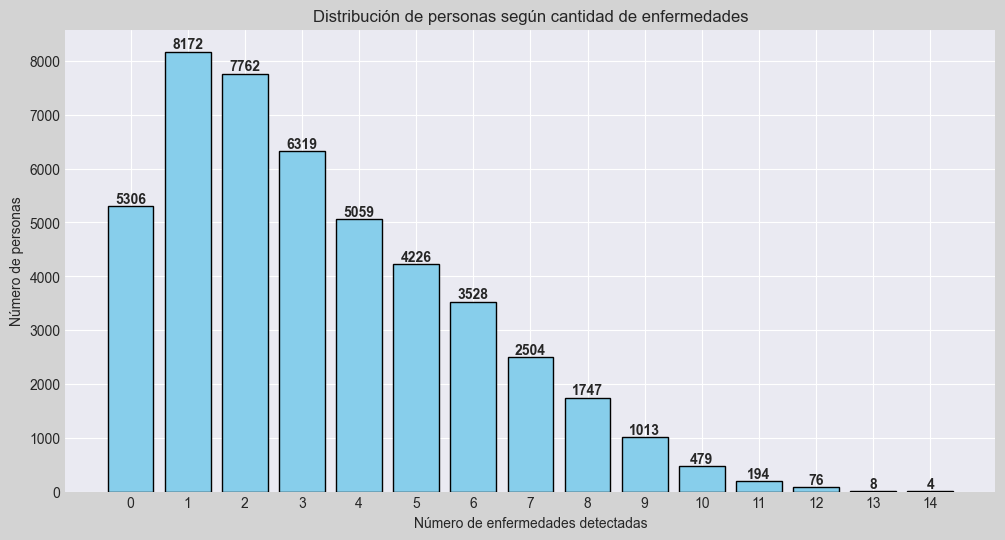

In [121]:
df.loc[:, "n_enfermedades"] = df[disease_cols].sum(axis=1)

rango = range(0, int(df["n_enfermedades"].max()) + 1)
conteo = df["n_enfermedades"].value_counts().reindex(rango, fill_value=0)

plt.figure(figsize=(12,6), facecolor="lightgrey")
bars = plt.bar(conteo.index, conteo.values, color="skyblue", edgecolor="black")

plt.xlabel("N√∫mero de enfermedades detectadas")
plt.ylabel("N√∫mero de personas")
plt.title("Distribuci√≥n de personas seg√∫n cantidad de enfermedades")
plt.xticks(conteo.index)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 1,
        f"{int(height)}",
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

plt.show()

### Notar que no existen registros con mas de 14 patolig√≠as a la vez